<a href="https://colab.research.google.com/github/ixd-ai-hub/Research-Ground/blob/project%2FCU-865d7myr5-shelf-object-detection/model/soft_NMS_%2B_GIoU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torch
import numpy as np

In [ ]:

def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) between two bounding boxes.
    :param box1: [x1, y1, x2, y2] (top-left and bottom-right coordinates)
    :param box2: [x1, y1, x2, y2] (top-left and bottom-right coordinates)
    :return: IoU value
    """
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    area_box1 = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    area_box2 = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    union = area_box1 + area_box2 - intersection

    iou = intersection / union
    return iou


def calculate_giou(box1, box2):
    """
    Calculate the Generalized IoU (GIoU) between two bounding boxes.
    :param box1: [x1, y1, x2, y2] (top-left and bottom-right coordinates)
    :param box2: [x1, y1, x2, y2] (top-left and bottom-right coordinates)
    :return: GIoU value
    """
    iou = calculate_iou(box1, box2)

    x1 = min(box1[0], box2[0])
    y1 = min(box1[1], box2[1])
    x2 = max(box1[2], box2[2])
    y2 = max(box1[3], box2[3])

    area_box1 = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    area_box2 = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    enclosing_area = (x2 - x1 + 1) * (y2 - y1 + 1)

    union = area_box1 + area_box2 - iou

    giou = iou - (enclosing_area - union) / enclosing_area
    return giou



def soft_nms(bounding_boxes, iou_threshold=0.3, sigma=0.5, score_threshold=0.001):
    """
    Apply the Soft-NMS algorithm with Generalized IoU (GIoU) to the bounding boxes.
    :param bounding_boxes: List of bounding boxes [x1, y1, x2, y2, score]
    :param iou_threshold: IoU threshold for suppressing overlapping boxes
    :param sigma: Parameter for controlling the Gaussian weighting function
    :param score_threshold: Minimum score threshold to keep a bounding box
    :return: List of filtered bounding boxes after applying Soft-NMS
    """
    sorted_boxes = bounding_boxes[np.argsort(bounding_boxes[:, 4])[::-1]]  # Sort by score in descending order
    num_boxes = len(sorted_boxes)

    for i in range(num_boxes):
        if sorted_boxes[i, 4] < score_threshold:
            break

        for j in range(i + 1, num_boxes):
            if sorted_boxes[j, 4] < score_threshold:
                break

            giou = calculate_giou(sorted_boxes[i, :4], sorted_boxes[j, :4])
            weight = np.exp(-(giou ** 2) / sigma)  # Gaussian weighting function
            sorted_boxes[j, 4] *= weight

            if sorted_boxes[j, 4] < score_threshold:
                sorted_boxes[j, :] = sorted_boxes[num_boxes - 1, :]
                num_boxes -= 1

            if giou > iou_threshold:
                sorted_boxes[j, 4] -= giou

    filtered_boxes = sorted_boxes[:num_boxes]
    return filtered_boxes


In [ ]:
shelf_id = 12
data_path = f'/content/drive/MyDrive/Shelf/Samples/shell{shelf_id}_full_labels.txt'
proposal_df = pd.read_csv(data_path, delimiter=" ", index_col=False,names=['x_min', 'y_min', 'x_max', 'y_max', 'conf'])
proposal_df.head()

,x_min,y_min,x_max,y_max,conf
0,1015,669,1058,719,0.988248
1,438,499,532,658,0.989016
2,533,497,621,651,0.988807
3,414,272,502,352,0.981845
4,224,504,340,674,0.989005


In [ ]:
filtered_boxes = soft_nms(proposal_df.values, iou_threshold=0.8, sigma=0.7, score_threshold=0.97)
filtered_df = pd.DataFrame(data=filtered_boxes, columns=['x_min', 'y_min', 'x_max', 'y_max', 'conf'])
filtered_df.head()

,x_min,y_min,x_max,y_max,conf
0,449.0,25.0,467.0,35.0,1.000000
1,855.0,527.0,873.0,609.0,0.950000
2,572.0,598.0,621.0,664.0,0.950263
3,769.0,312.0,790.0,358.0,0.950479
4,962.0,678.0,1212.0,719.0,0.951565


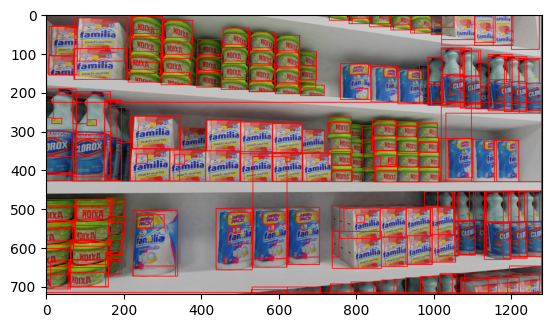

In [ ]:
img_dir = f"/content/drive/MyDrive/Shelf/Samples/shell{shelf_id}.jpg"
img = Image.open(img_dir,mode="r")
img = img.resize((1280,720))
for index,row in proposal_df.iterrows():
    x_min = float(row['x_min'])
    y_min = float(row['y_min'])
    x_max = float(row['x_max'])
    y_max = float(row['y_max'])
    conf = float(row['conf'])
    draw = ImageDraw.Draw(img)
    draw.rectangle([(x_min, y_min), (x_max, y_max)], outline='red',width=2)


plt.imshow(img)

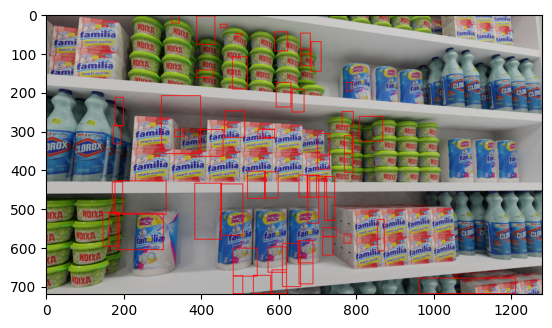

In [ ]:
img = Image.open(img_dir,mode="r")
img = img.resize((1280,720))
for index,row in filtered_df.iterrows():
    x_min = float(row['x_min'])
    y_min = float(row['y_min'])
    x_max = float(row['x_max'])
    y_max = float(row['y_max'])
    conf = float(row['conf'])
    draw = ImageDraw.Draw(img)
    draw.rectangle([(x_min, y_min), (x_max, y_max)], outline='red',width=2)


plt.imshow(img)